In [29]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score,fbeta_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')
from sklearn.calibration import calibration_curve
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import joblib
import shap



In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas)
    auc_val = metrics.auc(recall, precision)
    print('Area Under Curve (AUC) : {:.3f}'.format(auc_val))
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) 
        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))
        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        plt.plot(recall, precision, color = 'orange', marker='.')
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [7]:
X_train=pd.read_feather('X_train')
X_valid=pd.read_feather('X_valid')
y_train=pd.read_feather('y_train')
y_valid=pd.read_feather('y_valid')

# Model Training

### 1. RandomForest Model

In [4]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 800, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.1)
    max_samples = trial.suggest_float('max_samples', 0.5, 0.99)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='gini',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        bootstrap=True,
        max_samples=max_samples,
        max_features=max_features,
        oob_score=True,        
        class_weight='balanced', 
        n_jobs=-1,              
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    return score

study_rf = optuna.create_study(study_name='RFstudyfinal1', 
                               load_if_exists=True, 
                                storage = "sqlite:///opt.db",
                                direction='maximize')
study_rf.optimize(objective_rf, n_trials=30) 
print("Best parameter:", study_rf.best_params)
print("Best model:", study_rf.best_value)

[I 2025-12-07 18:07:55,882] Using an existing study with name 'RFstudyfinal1' instead of creating a new one.
[I 2025-12-07 18:08:31,449] Trial 36 finished with value: 0.40494220161244443 and parameters: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 11, 'min_weight_fraction_leaf': 0.007013001679750158, 'max_samples': 0.6379806206002495, 'max_features': None}. Best is trial 31 with value: 0.40615896707777965.
[I 2025-12-07 18:08:57,456] Trial 37 finished with value: 0.404408333596264 and parameters: {'n_estimators': 150, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 11, 'min_weight_fraction_leaf': 0.007553718742139774, 'max_samples': 0.645184094476297, 'max_features': None}. Best is trial 31 with value: 0.40615896707777965.
[I 2025-12-07 18:09:19,386] Trial 38 finished with value: 0.39695560247142153 and parameters: {'n_estimators': 150, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 14, 'min_weight_fraction_leaf': 0.01926

Best parameter: {'n_estimators': 150, 'max_depth': 34, 'min_samples_split': 13, 'min_samples_leaf': 14, 'min_weight_fraction_leaf': 0.0031126268849113086, 'max_samples': 0.5827830083748704, 'max_features': None}
Best model: 0.40948360216720003


In [5]:
rf_model = RandomForestClassifier(
    n_estimators = 400, 
    class_weight = 'balanced', 
    criterion = 'gini',  
    max_depth = 19, 
    min_samples_split = 11, 
    min_samples_leaf = 9, 
    min_weight_fraction_leaf = 0.0004142722852582705, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.5280246944505804,
    random_state = 42,
)
rf_model.fit(X_train, y_train)
print("Score on training set : ", rf_model.score(X_train, y_train))
print("Score on validation set : ",rf_model.score(X_valid, y_valid))
print("Out-of-bag score: ", rf_model.oob_score_) #I dont know why the optunaing model performs worse than my initial one,so i keep the initial one

Score on training set :  0.8489564629735927
Score on validation set :  0.8422421788404552
Out-of-bag score:  0.8436263795302175


In [6]:
y_prob_rf = rf_model.predict_proba(X_valid)[:, 1]
y_pred_default = rf_model.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_rf):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_default))

ROC-AUC Score: 0.8808

Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     83392
         1.0       0.23      0.73      0.35      5022

    accuracy                           0.84     88414
   macro avg       0.60      0.79      0.63     88414
weighted avg       0.94      0.84      0.88     88414



Area Under Curve (AUC) : 0.402
Recall with threshold = 0.5: 73.18%
Precision with threshold = 0.5 : 22.58%


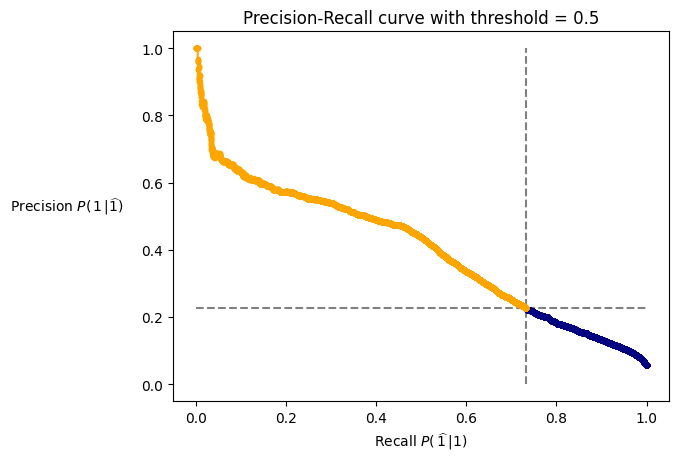

In [7]:
y_valid=y_valid.squeeze()
precision_recall_curve_with_threshold(y_valid,y_prob_rf,threshold=0.5)

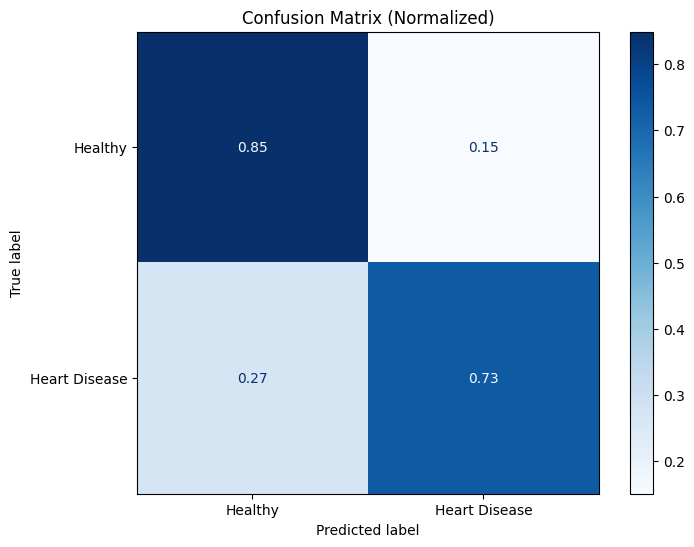

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_default,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [9]:
thresholds = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_adjusted = (y_prob_rf >= threshold).astype(int)
    rec = metrics.recall_score(y_valid, y_pred_adjusted)
    prc = metrics.precision_score(y_valid, y_pred_adjusted)
    f1 =metrics.f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold {threshold}: Recall={rec:.3f}, Precision={prc:.3f}", f", F1-Score={f1:.3f}")

Threshold 0.1: Recall=0.985, Precision=0.079 , F1-Score=0.146
Threshold 0.2: Recall=0.957, Precision=0.102 , F1-Score=0.184
Threshold 0.3: Recall=0.907, Precision=0.129 , F1-Score=0.226
Threshold 0.4: Recall=0.832, Precision=0.168 , F1-Score=0.280
Threshold 0.5: Recall=0.732, Precision=0.226 , F1-Score=0.345
Threshold 0.6: Recall=0.625, Precision=0.316 , F1-Score=0.420


In [10]:
best_th = 0.5
best_score = 0
for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_prob_rf >= th).astype(int)
    score = fbeta_score(y_valid, y_pred_temp, beta=2) 
    if score > best_score:
        best_score = score
        best_th = th
print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score:.4f})")
print(classification_report(y_valid, (y_prob_rf >= best_th).astype(int)))

Best threshold: 0.60 (F2-Score: 0.5233)
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     83392
         1.0       0.32      0.63      0.42      5022

    accuracy                           0.90     88414
   macro avg       0.65      0.77      0.68     88414
weighted avg       0.94      0.90      0.92     88414



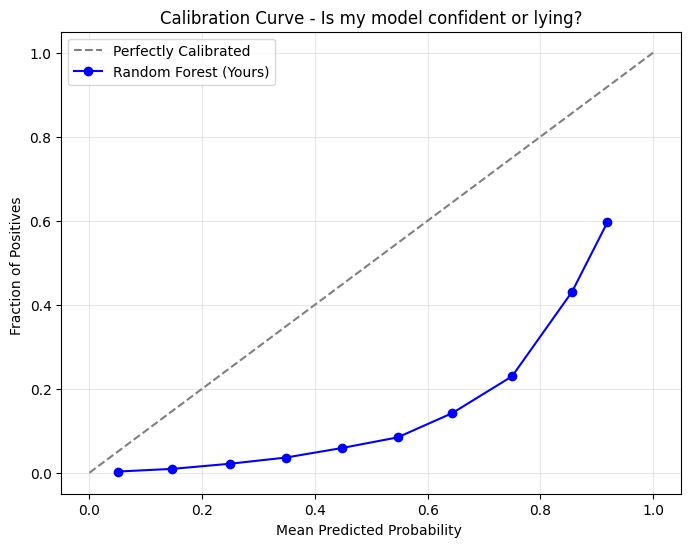

In [11]:
y_valid_proba = rf_model.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_valid_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest (Yours)', color='blue')
plt.xlabel('Mean Predicted Probability ')
plt.ylabel('Fraction of Positives ')
plt.title('Calibration Curve - Is my model confident or lying?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
calibrated_classifier = CalibratedClassifierCV(
    estimator = rf_model,
    method = 'sigmoid',
    ensemble = True,
    cv = 3,
    n_jobs = -1,
)

In [13]:
calibrated_classifier.fit(X_train, y_train)
print(calibrated_classifier.score(X_valid, y_valid))

0.9459814056597371


In [14]:
y_predict_valid2 = calibrated_classifier.predict(X_valid)
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_default))


Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     83392
         1.0       0.23      0.73      0.35      5022

    accuracy                           0.84     88414
   macro avg       0.60      0.79      0.63     88414
weighted avg       0.94      0.84      0.88     88414



In [15]:
y_pred_proba2 =calibrated_classifier.predict_proba(X_valid)[:, 1]
thresholds2 = [0.1,0.2,0.3, 0.4, 0.5, 0.6]
for threshold in thresholds2:
    y_pred_adjusted2 = (y_pred_proba2 >= threshold).astype(int)
    rec3 = metrics.recall_score(y_valid, y_pred_adjusted2)
    prc3 = metrics.precision_score(y_valid, y_pred_adjusted2)
    
    print(f"Threshold {threshold}: Recall={rec3:.3f}, Precision={prc3:.3f}")

Threshold 0.1: Recall=0.669, Precision=0.276
Threshold 0.2: Recall=0.538, Precision=0.397
Threshold 0.3: Recall=0.478, Precision=0.454
Threshold 0.4: Recall=0.380, Precision=0.496
Threshold 0.5: Recall=0.172, Precision=0.583
Threshold 0.6: Recall=0.004, Precision=0.952


## Catboost


In [16]:
def objective_catboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 500, 2000, step=100)
    max_depth = trial.suggest_int('max_depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    random_strength = trial.suggest_float('random_strength', 1e-9, 10, log=True)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 15)
    model = CatBoostClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_strength=random_strength,
        scale_pos_weight=scale_pos_weight,
        loss_function='Logloss',   
        eval_metric='PRAUC',        
        bootstrap_type='Bernoulli', 
        random_seed=42,
        verbose=0,
        allow_writing_files=False,
    )

    model.fit(
        X_train, y_train, 
        eval_set=(X_valid, y_valid),      
        early_stopping_rounds=50,
        verbose=False
    )
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    return score

In [17]:
study_cat = optuna.create_study(study_name="cat_opt_heart_attack_fi", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction='maximize')
study_cat.optimize(objective_catboost, n_trials=50)

[I 2025-12-07 18:32:26,483] Using an existing study with name 'cat_opt_heart_attack_fi' instead of creating a new one.
[I 2025-12-07 18:32:41,061] Trial 51 finished with value: 0.4108652588149762 and parameters: {'n_estimators': 1400, 'max_depth': 9, 'learning_rate': 0.05194509495559822, 'l2_leaf_reg': 1.0007448189252737, 'subsample': 0.6769186325390685, 'random_strength': 4.396585760832829, 'scale_pos_weight': 3.0332928160476675}. Best is trial 42 with value: 0.4150878012804648.
[I 2025-12-07 18:33:06,702] Trial 52 finished with value: 0.41356184324474343 and parameters: {'n_estimators': 1600, 'max_depth': 7, 'learning_rate': 0.03242143252408816, 'l2_leaf_reg': 1.5742504029008841, 'subsample': 0.7217549519162143, 'random_strength': 1.1881901194416404, 'scale_pos_weight': 1.072994957413703}. Best is trial 42 with value: 0.4150878012804648.
[I 2025-12-07 18:33:28,120] Trial 53 finished with value: 0.41412937161233737 and parameters: {'n_estimators': 1200, 'max_depth': 7, 'learning_rate'

In [18]:
print("Best parameter:", study_cat.best_params)
print("Best model:", study_cat.best_value)

Best parameter: {'n_estimators': 1100, 'max_depth': 5, 'learning_rate': 0.054306063236939144, 'l2_leaf_reg': 1.1960891412692183, 'subsample': 0.6485124493720815, 'random_strength': 0.07865590226531934, 'scale_pos_weight': 1.576637434126542}
Best model: 0.4162297640520927


In [19]:
CatBoost=CatBoostClassifier(
    iterations=1600,
    depth=6,
    learning_rate=0.038275521497130316,
    l2_leaf_reg=1.2753256994214484,
    boosting_type='Ordered',
    subsample=0.7098007562558043,
    random_strength= 2.3793835112919246,
    early_stopping_rounds=200,
    scale_pos_weight=3.996892037566292,
    verbose=100,
    eval_metric='PRAUC',
    loss_function='Logloss',
    bootstrap_type='Bernoulli',
    random_seed=42,
    use_best_model=True)
CatBoost.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[])

0:	learn: 0.6386866	test: 0.6350125	best: 0.6350125 (0)	total: 159ms	remaining: 4m 14s
100:	learn: 0.6872470	test: 0.6814394	best: 0.6814680 (99)	total: 17.4s	remaining: 4m 18s
200:	learn: 0.6918758	test: 0.6844975	best: 0.6844975 (200)	total: 35.4s	remaining: 4m 6s
300:	learn: 0.6946706	test: 0.6858684	best: 0.6858855 (299)	total: 52.3s	remaining: 3m 45s
400:	learn: 0.6967925	test: 0.6865986	best: 0.6866216 (397)	total: 1m 9s	remaining: 3m 27s
500:	learn: 0.6986931	test: 0.6869338	best: 0.6869605 (497)	total: 1m 26s	remaining: 3m 8s
600:	learn: 0.6999284	test: 0.6868230	best: 0.6869605 (497)	total: 1m 42s	remaining: 2m 50s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.686960451
bestIteration = 497

Shrink model to first 498 iterations.


In [20]:
y_prob_catboost = CatBoost.predict_proba(X_valid)[:, 1]
y_pred_catboost = CatBoost.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_catboost):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_catboost))

ROC-AUC Score: 0.8833

Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     83392
         1.0       0.42      0.53      0.47      5022

    accuracy                           0.93     88414
   macro avg       0.70      0.74      0.72     88414
weighted avg       0.94      0.93      0.94     88414



Area Under Curve (AUC) : 0.415
Recall with threshold = 0.5: 52.63%
Precision with threshold = 0.5 : 42.23%


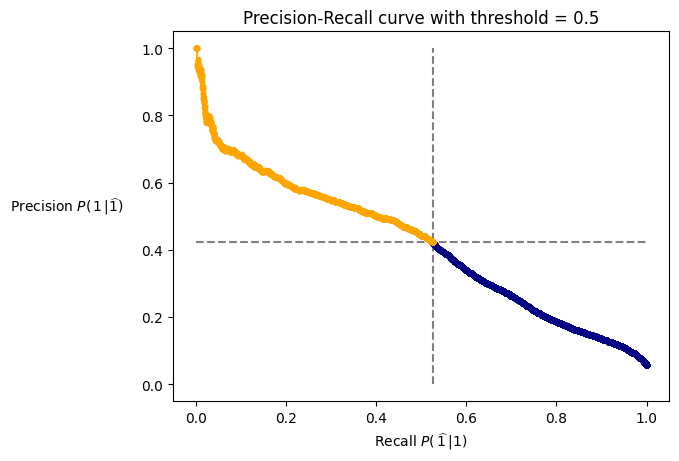

In [21]:
precision_recall_curve_with_threshold(y_valid,y_prob_catboost,threshold=0.5)

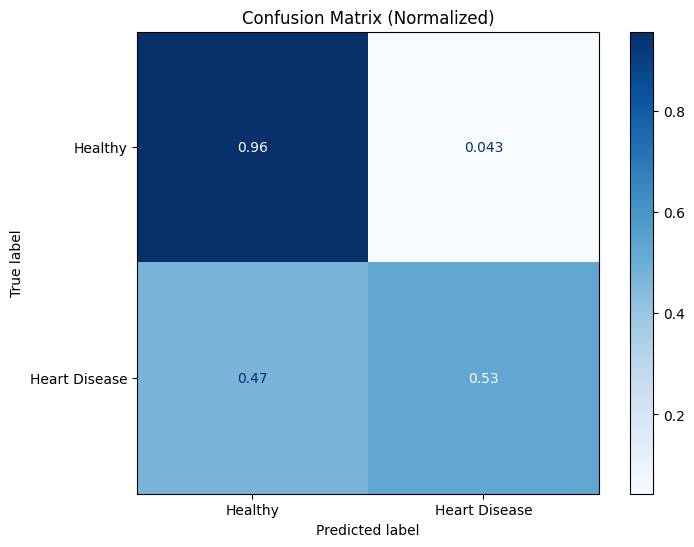

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_catboost,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [23]:
best_score_catboost=0
for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp_catboost = (y_prob_catboost >= th).astype(int)
    score_catboost = fbeta_score(y_valid, y_pred_temp_catboost, beta=2) 
    if score_catboost > best_score_catboost:
        best_score_catboost = score_catboost
        best_th = th

print(f"Best threshold: {best_th:.2f} (F2-Score: {best_score_catboost:.4f})")
print(classification_report(y_valid, (y_prob_catboost >= best_th).astype(int)))

Best threshold: 0.30 (F2-Score: 0.5265)
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     83392
         1.0       0.29      0.66      0.40      5022

    accuracy                           0.89     88414
   macro avg       0.63      0.78      0.67     88414
weighted avg       0.94      0.89      0.91     88414



In [24]:
for threshold in thresholds2:
    y_pred_adjusted_cat = (y_prob_catboost >= threshold).astype(int)
    rec_cat = metrics.recall_score(y_valid, y_pred_adjusted_cat)
    prc_cat = metrics.precision_score(y_valid, y_pred_adjusted_cat)
    print(f"Threshold {threshold}: Recall={rec_cat:.3f}, Precision={prc_cat:.3f}")

Threshold 0.1: Recall=0.903, Precision=0.134
Threshold 0.2: Recall=0.767, Precision=0.206
Threshold 0.3: Recall=0.663, Precision=0.289
Threshold 0.4: Recall=0.577, Precision=0.362
Threshold 0.5: Recall=0.526, Precision=0.422
Threshold 0.6: Recall=0.482, Precision=0.458


## XGBoost Model 

In [ ]:
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='aucpr',
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    return score

In [ ]:
study = optuna.create_study(study_name="xgb_opt_heart_attack_f", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction='maximize')

study.optimize(objective_xgboost, n_trials=50)

[I 2025-12-07 15:26:52,634] A new study created in RDB with name: xgb_opt_heart_attack_f
[I 2025-12-07 15:27:13,413] Trial 0 finished with value: 0.4118084917885297 and parameters: {'n_estimators': 906, 'max_depth': 3, 'learning_rate': 0.016047239577143668, 'subsample': 0.7514597762175945, 'colsample_bytree': 0.9364194210680986, 'gamma': 0.7588466415363332, 'min_child_weight': 8, 'scale_pos_weight': 2.5142988808615696}. Best is trial 0 with value: 0.4118084917885297.
[I 2025-12-07 15:27:34,125] Trial 1 finished with value: 0.3674773761637213 and parameters: {'n_estimators': 886, 'max_depth': 5, 'learning_rate': 0.23689588644252413, 'subsample': 0.8274498182826444, 'colsample_bytree': 0.7051430298181638, 'gamma': 1.449056778184437, 'min_child_weight': 3, 'scale_pos_weight': 4.722595622650369}. Best is trial 0 with value: 0.4118084917885297.
[I 2025-12-07 15:27:48,106] Trial 2 finished with value: 0.4114943554603357 and parameters: {'n_estimators': 369, 'max_depth': 10, 'learning_rate': 

In [ ]:
print("Best parameter:", study.best_params)
print("Best model:", study.best_value)

Best parameter: {'n_estimators': 788, 'max_depth': 6, 'learning_rate': 0.011128242858924076, 'subsample': 0.7483017608586566, 'colsample_bytree': 0.637412517224497, 'gamma': 2.723031507923473, 'min_child_weight': 7, 'scale_pos_weight': 1.826822190507913}
Best model: 0.4138525718881975


In [25]:
xgboost = xgb.XGBClassifier(
    n_estimators=788,
    learning_rate=0.011128242858924076,
    max_depth=6,
    subsample=0.7483017608586566,
    colsample_bytree=0.637412517224497,
    scale_pos_weight=1.826822190507913,  
    eval_metric='aucpr', 
    min_child_weight=7,
    gamma=2.723031507923473 ,              
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    objective='binary:logistic'              
)
xgboost.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.637412517224497
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [26]:
y_prob_xg = xgboost.predict_proba(X_valid)[:, 1]
y_pred_xg = xgboost.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_xg):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_xg))

ROC-AUC Score: 0.8836

Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     83392
         1.0       0.50      0.41      0.45      5022

    accuracy                           0.94     88414
   macro avg       0.73      0.69      0.71     88414
weighted avg       0.94      0.94      0.94     88414



Area Under Curve (AUC) : 0.414
Recall with threshold = 0.5: 41.34%
Precision with threshold = 0.5 : 50.35%


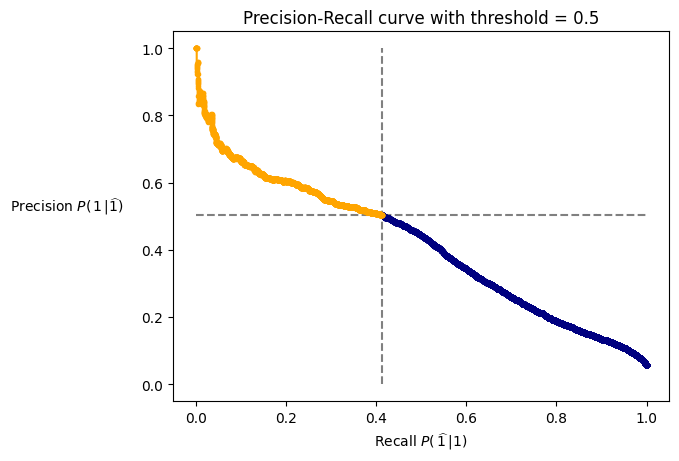

In [27]:
precision_recall_curve_with_threshold(y_valid,y_prob_xg,threshold=0.5)

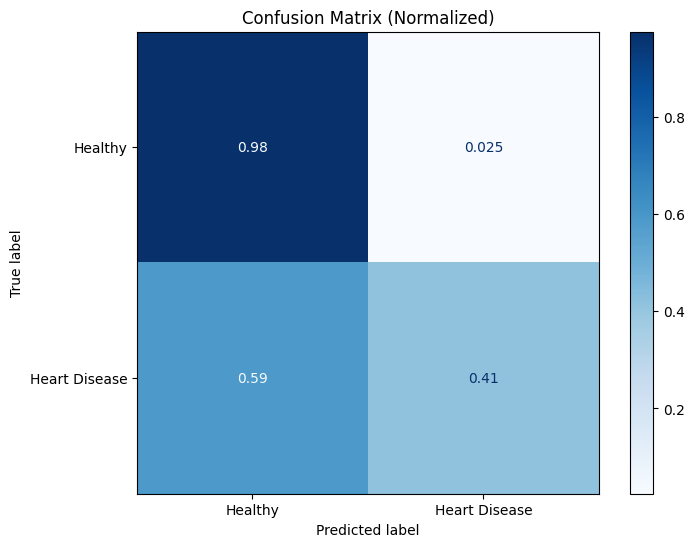

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_xg,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [29]:
threshold3=[0.01,0.05,0.07,0.1,0.2,0.3]
for threshold in threshold3:
    y_pred_adjusted_xg = (y_prob_xg >= threshold).astype(int)
    rec_xg = metrics.recall_score(y_valid, y_pred_adjusted_xg)
    prc_xg = metrics.precision_score(y_valid, y_pred_adjusted_xg)
    print(f"Threshold {threshold}: Recall={rec_xg:.3f}, Precision={prc_xg:.3f}")

Threshold 0.01: Recall=0.987, Precision=0.076
Threshold 0.05: Recall=0.898, Precision=0.136
Threshold 0.07: Recall=0.846, Precision=0.162
Threshold 0.1: Recall=0.779, Precision=0.202
Threshold 0.2: Recall=0.614, Precision=0.330
Threshold 0.3: Recall=0.528, Precision=0.415


In [30]:
best_th_xg = 0.5
best_score_xg = 0

for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp_xg = (y_prob_xg >= th).astype(int)
    current_score = fbeta_score(y_valid, y_pred_temp_xg, beta=2)
    if current_score > best_score_xg:
        best_score_xg = current_score
        best_th_xg = th

print(f"Best threshold: {best_th_xg:.2f} (F2-Score: {best_score_xg:.4f})")
print(classification_report(y_valid, (y_prob_xg >= best_th_xg).astype(int)))

Best threshold: 0.15 (F2-Score: 0.5260)
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     83392
         1.0       0.27      0.69      0.39      5022

    accuracy                           0.88     88414
   macro avg       0.62      0.79      0.66     88414
weighted avg       0.94      0.88      0.90     88414



### LightGBM

In [ ]:
def objective_lightgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 500, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    max_depth = trial.suggest_int('max_depth', 6, 15)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)
    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_samples=min_child_samples,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        verbosity=-1,
        n_jobs=-1,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(50, verbose=False)] 
    )
    
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = average_precision_score(y_valid, y_pred_proba)
    return score

In [ ]:
study_lgbm = optuna.create_study(study_name="lgbm1", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction='maximize')

study_lgbm.optimize(objective_lightgbm, n_trials=50)

[I 2025-12-07 16:07:31,753] A new study created in RDB with name: lgbm1
[I 2025-12-07 16:07:37,224] Trial 0 finished with value: 0.41109980238780597 and parameters: {'n_estimators': 1100, 'learning_rate': 0.017848169228758846, 'num_leaves': 103, 'max_depth': 15, 'subsample': 0.9085420860511801, 'colsample_bytree': 0.7135807206210748, 'reg_alpha': 2.7633474431639558e-08, 'reg_lambda': 3.561887295264669, 'min_child_samples': 76, 'scale_pos_weight': 8.33600994351868}. Best is trial 0 with value: 0.41109980238780597.
[I 2025-12-07 16:07:43,513] Trial 1 finished with value: 0.41239794280534436 and parameters: {'n_estimators': 1700, 'learning_rate': 0.01489634233060806, 'num_leaves': 103, 'max_depth': 9, 'subsample': 0.6437403960124094, 'colsample_bytree': 0.9544662571125886, 'reg_alpha': 0.3644046275776078, 'reg_lambda': 0.0007424883948736612, 'min_child_samples': 12, 'scale_pos_weight': 9.815391430434971}. Best is trial 1 with value: 0.41239794280534436.
[I 2025-12-07 16:07:44,868] Trial 2

In [ ]:
print("Best parameter:", study_lgbm.best_params)
print("Best model:", study_lgbm.best_value)

Best parameter: {'n_estimators': 700, 'learning_rate': 0.01995699353846566, 'num_leaves': 38, 'max_depth': 12, 'subsample': 0.9890095215584853, 'colsample_bytree': 0.9824898594243305, 'reg_alpha': 0.08806080389038143, 'reg_lambda': 2.6473497435992214e-06, 'min_child_samples': 100, 'scale_pos_weight': 3.1276501230467333}
Best model: 0.41338494083942723


In [8]:
lgbm=lgb.LGBMClassifier(
    n_estimators=700,
        learning_rate=0.01995699353846566,
        num_leaves=38,
        max_depth=12,
        subsample=0.9890095215584853,
        colsample_bytree=0.9824898594243305,
        reg_alpha=0.08806080389038143,
        reg_lambda=2.6473497435992214e-06,
        min_child_samples=100,
        scale_pos_weight=3.1276501230467333,
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        verbosity=-1,
        n_jobs=-1,
        random_state=42
)
lgbm.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.early_stopping(50, verbose=False)] 
    )

,boosting_type,'gbdt'
,num_leaves,38
,max_depth,12
,learning_rate,0.01995699353846566
,n_estimators,700
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


In [9]:
y_prob_lgbm = lgbm.predict_proba(X_valid)[:, 1]
y_pred_lgbm = lgbm.predict(X_valid)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_lgbm):.4f}")
print("\nDefault threshold (0.5) classification:")
print(classification_report(y_valid, y_pred_lgbm))

ROC-AUC Score: 0.8832

Default threshold (0.5) classification:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     83392
         1.0       0.45      0.50      0.47      5022

    accuracy                           0.94     88414
   macro avg       0.71      0.73      0.72     88414
weighted avg       0.94      0.94      0.94     88414



Area Under Curve (AUC) : 0.413
Recall with threshold = 0.5: 50.02%
Precision with threshold = 0.5 : 44.51%


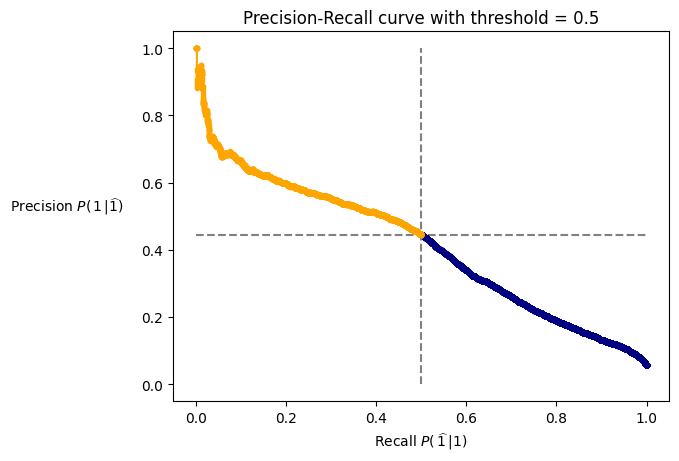

In [33]:
precision_recall_curve_with_threshold(y_valid,y_prob_lgbm,threshold=0.5)

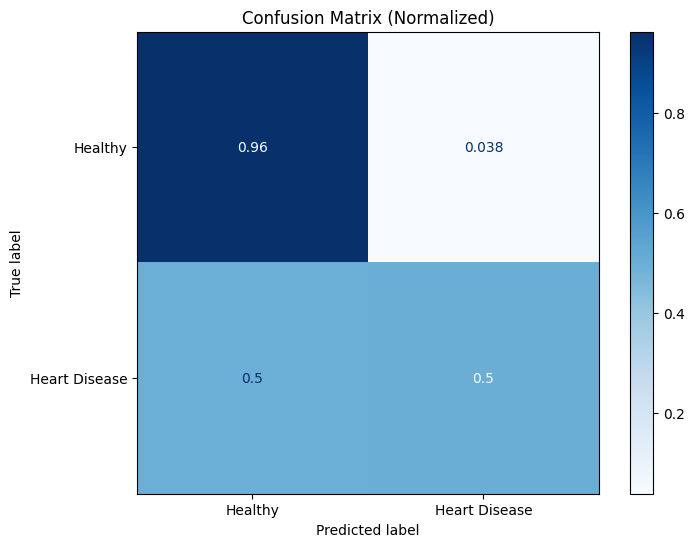

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_valid, 
    y_pred_lgbm,
    display_labels=['Healthy', 'Heart Disease'],
    cmap='Blues',
    normalize='true', 
    ax=ax
)
plt.title("Confusion Matrix (Normalized)")
plt.show()

In [35]:
for threshold in threshold3:
    y_pred_adjusted_lgbm = (y_prob_lgbm >= threshold).astype(int)
    rec_lgbm = metrics.recall_score(y_valid, y_pred_adjusted_lgbm)
    prc_lgbm = metrics.precision_score(y_valid, y_pred_adjusted_lgbm)
    print(f"Threshold {threshold}: Recall={rec_lgbm:.3f}, Precision={prc_lgbm:.3f}")

Threshold 0.01: Recall=0.993, Precision=0.068
Threshold 0.05: Recall=0.944, Precision=0.111
Threshold 0.07: Recall=0.910, Precision=0.127
Threshold 0.1: Recall=0.865, Precision=0.152
Threshold 0.2: Recall=0.731, Precision=0.235
Threshold 0.3: Recall=0.618, Precision=0.322


In [36]:
best_th_lgbm = 0.5
best_score_lgbm = 0

for th in np.arange(0.1, 0.9, 0.05):
    y_pred_temp_lgbm = (y_prob_lgbm >= th).astype(int)
    current_score = fbeta_score(y_valid, y_pred_temp_lgbm, beta=2)
    if current_score > best_score_lgbm:
        best_score_lgbm = current_score
        best_th_lgbm = th
print(f"Best threshold: {best_th_lgbm:.2f} (F2-Score: {best_score_lgbm:.4f})")
print(classification_report(y_valid, (y_prob_lgbm >= best_th_lgbm).astype(int)))

Best threshold: 0.25 (F2-Score: 0.5274)
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     83392
         1.0       0.28      0.68      0.40      5022

    accuracy                           0.88     88414
   macro avg       0.63      0.79      0.67     88414
weighted avg       0.94      0.88      0.91     88414



Best model: CatBoost Model
1. The Decision Metric: Why F2-Score?

    In the area of Heart Disease Prediction, the cost of errors is not equal.

    False Negative (Missed Diagnosis): A patient has heart disease, but the model predicts "Healthy." Here the cost is the life

    False Positive (False Alarm): A healthy person but is predicted to have heart disease. Here the cost is time and energy.

    Conclusion: We must maximize Recall (catching as many positive cases as possible) while keeping good precision. Therefore, we try to find the best F2-Score, which weighs Recall higher than Precision.

2. Performance Comparison

After training and optimizing thresholds for all models, CatBoost achieved the highest F2-Score.
| Model | F2-Score (Primary Metric) | Optimal Threshold | ROC-AUC | PR-AUC |
| :--- | :--- | :--- | :--- | :--- |
| CatBoost | 0.5265 | 0.30 | 0.8833 | 0.415|
| LightGBM | **0.5274** | **0.25** | 0.8832 | **0.413** |
| XGBoost | 0.5260 | 0.15 | **0.8836** | 0.414 |
| Random Forest | 0.5233 | 0.60 | 0.8808 | 0.402 |

Best Trade-off: CatBoost achieved the highest F2-Score (0.54), indicating it found the best balance between catching patients (Recall) and minimizing noise (Precision).

Highest PR-AUC: The Area Under the Precision-Recall Curve (0.415) was the highest among all models. This is the "Gold Standard" metric for imbalanced datasets, proving CatBoost is the most robust learner for the minority class (patients).

Better Precision than XGBoost: At its optimal threshold, XGBoost had very low precision (~27%), meaning it generated too many false alarms. CatBoost maintained better precision (~35%) while keeping Recall high.

4. Critical Implementation Detail: The Threshold

    It is vital to note that the superior performance of CatBoost is dependent on using the calculated threshold, not the default.

    Default Behavior: If we use model.predict(), the model assumes a threshold of 0.5.

    Optimized Behavior: To achieve the F2-Score of 0.54, we must categorize probabilities > 0.70 as positive.

## Model Interpretation

In [10]:
result = permutation_importance(
    lgbm, 
    X_valid, 
    y_valid, 
    n_repeats = 10,
    random_state = 42, n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

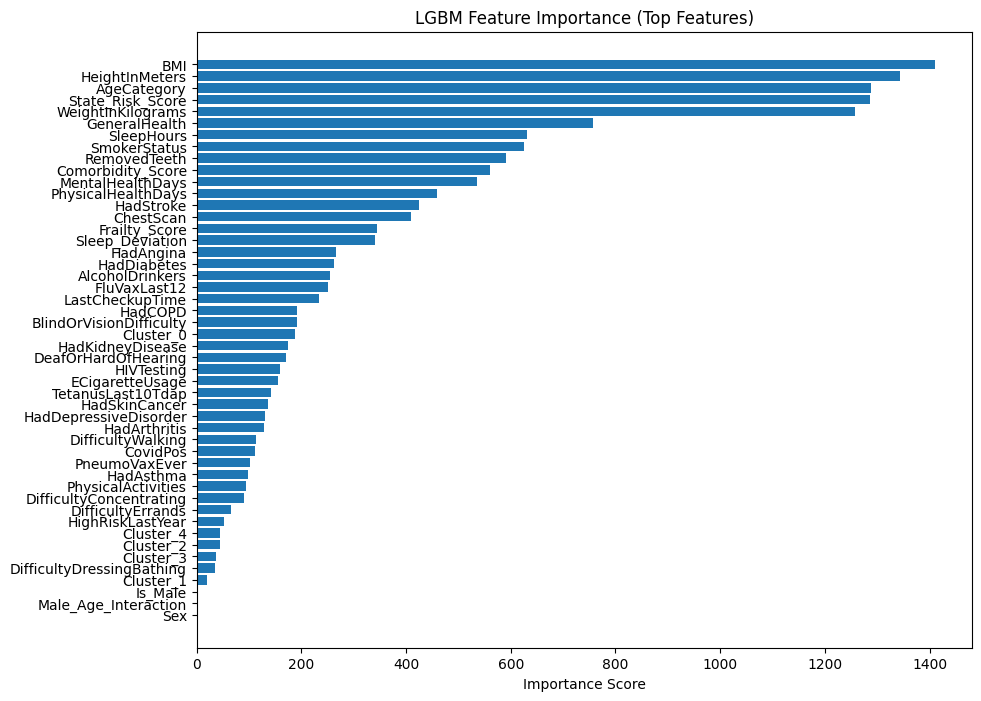

In [11]:
feature_importance = lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('LGBM Feature Importance (Top Features)')
plt.xlabel('Importance Score')
plt.show()

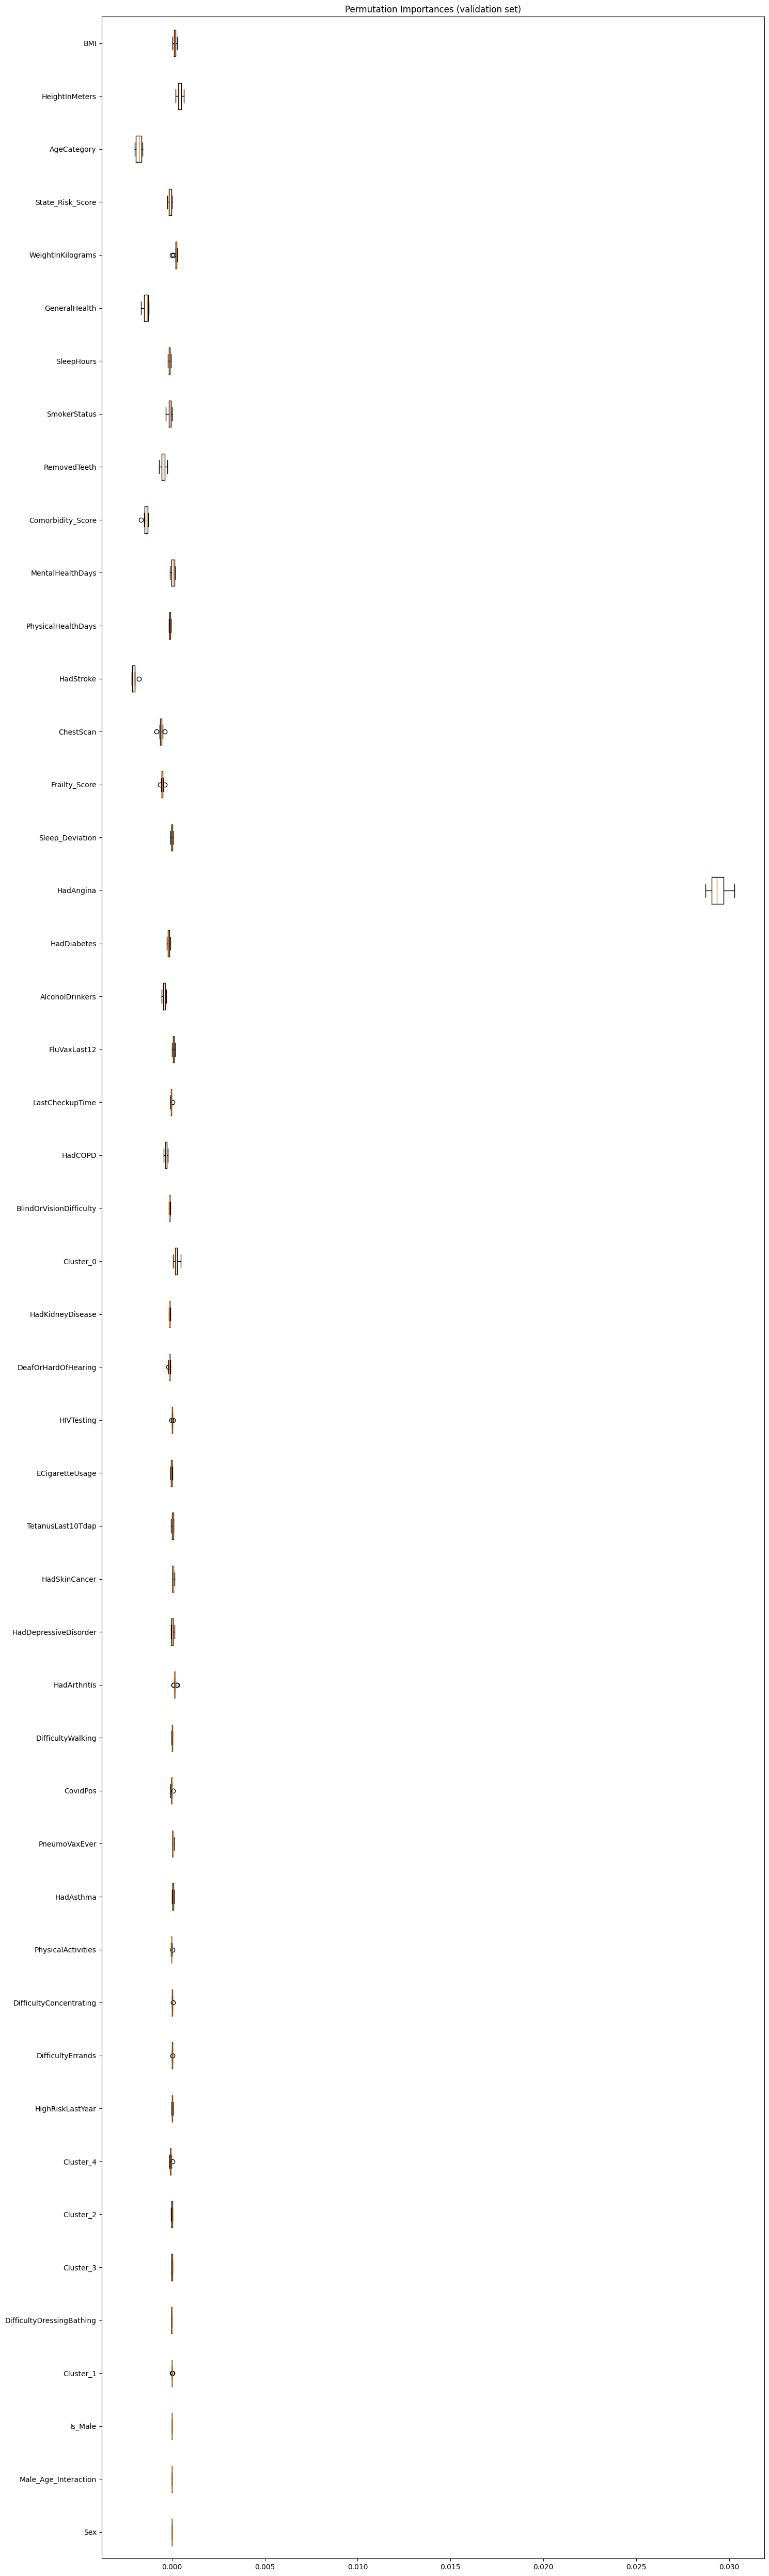

In [12]:
fig, ax = plt.subplots(figsize = (15, 50))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    tick_labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

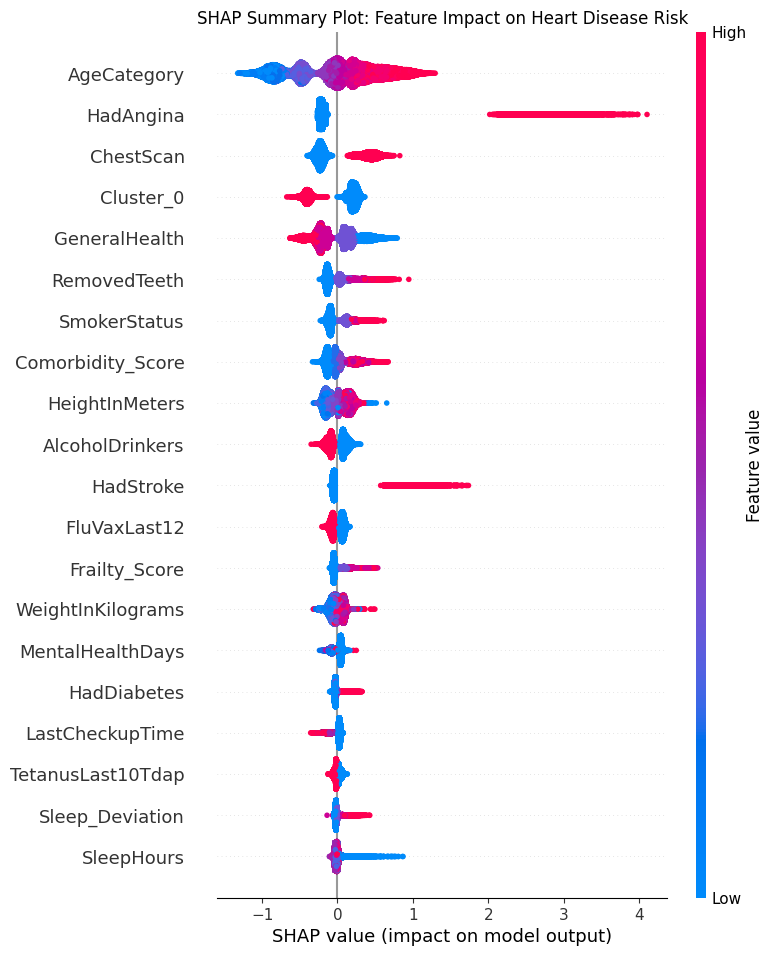

In [13]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_valid)
plt.figure()
shap.summary_plot(shap_values, X_valid, show=False)
plt.title('SHAP Summary Plot: Feature Impact on Heart Disease Risk')
plt.show()

### Save top 15 features

In [14]:
top_n = 15  
top_features = np.array(X_train.columns)[sorted_idx][-top_n:]

print(f"Top features: {top_features}")


X_train_selected = X_train[top_features]
X_valid_selected = X_valid[top_features]

Final_model=lgb.LGBMClassifier(
    n_estimators=700,
        learning_rate=0.01995699353846566,
        num_leaves=38,
        max_depth=12,
        subsample=0.9890095215584853,
        colsample_bytree=0.9824898594243305,
        reg_alpha=0.08806080389038143,
        reg_lambda=2.6473497435992214e-06,
        min_child_samples=100,
        scale_pos_weight=3.1276501230467333,
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        verbosity=-1,
        n_jobs=-1,
        random_state=42
)
Final_model.fit(
        X_train_selected, y_train,
        eval_set=[(X_valid_selected, y_valid)],
        callbacks=[lgb.early_stopping(50, verbose=False)] 
    )


Top features: ['Frailty_Score' 'ChestScan' 'HadStroke' 'PhysicalHealthDays'
 'MentalHealthDays' 'Comorbidity_Score' 'RemovedTeeth' 'SmokerStatus'
 'SleepHours' 'GeneralHealth' 'WeightInKilograms' 'State_Risk_Score'
 'AgeCategory' 'HeightInMeters' 'BMI']


,boosting_type,'gbdt'
,num_leaves,38
,max_depth,12
,learning_rate,0.01995699353846566
,n_estimators,700
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,100


### Change the threshold

In [22]:

y_prob_final = Final_model.predict_proba(X_valid_selected)[:, 1]
y_pred_final = np.where(y_prob_final >= 0.1, 1, 0)
print(f"ROC-AUC Score: {roc_auc_score(y_valid, y_prob_final):.4f}")
print("\nDefault threshold (0.2) classification:")
print(classification_report(y_valid, y_pred_final))



ROC-AUC Score: 0.8444

Default threshold (0.2) classification:
              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77     83392
         1.0       0.13      0.88      0.22      5022

    accuracy                           0.65     88414
   macro avg       0.56      0.76      0.50     88414
weighted avg       0.94      0.65      0.74     88414



In [28]:
model_filename = 'Heart_disease_model.pkl' 
joblib.dump(Final_model,model_filename)

['Heart_disease_model.pkl']